# To test out wide to long in pandas

- Read the data from HandBookData.xlsx
- read only the required cells [A1:AB1827]
- change from wide to long using pandas functionality.
- Use the statistics obtained from test1 notebook
- Write a model using SVR using multiple variables.
- Look for a way to tune the model

In [1]:
import pandas as pd
import numpy as np
import openpyxl
from datetime import datetime, timedelta
from os.path import join, splitext

In [2]:
data = pd.read_excel('HandBookData.xlsx', sheet_name='DPLLoad', engine='openpyxl', usecols='A:AB', nrows=1826)

data.sample(5)

,Season,Month,DOW,DT,HR1,HR2,HR3,HR4,HR5,HR6,...,HR15,HR16,HR17,HR18,HR19,HR20,HR21,HR22,HR23,HR24
45,Winter,2,Friday,2013-02-15,1839,1807.0,1789.0,1788,1851,1966,...,2207,2169,2174,2213,2283,2287,2255,2208,2108,2000
1635,Summer,6,Saturday,2017-06-24,1643,1537.0,1473.0,1434,1416,1426,...,2018,2049,2068,2076,2066,2008,1915,1854,1762,1627
723,Winter,12,Thursday,2014-12-25,1564,1499.0,1472.0,1470,1480,1507,...,1700,1678,1675,1757,1797,1787,1795,1777,1735,1662
1554,Spring,4,Tuesday,2017-04-04,1580,1524.0,1472.0,1471,1498,1611,...,1944,1896,1889,1897,1870,1874,1952,1916,1809,1697
343,Winter,12,Tuesday,2013-12-10,2082,2036.0,2018.0,2024,2073,2204,...,2384,2362,2411,2604,2681,2660,2631,2517,2407,2275


In [3]:
long_data = pd.wide_to_long(data, stubnames='HR', i=['Season','Month','DT','DOW'], j='hour')
long_data.reset_index(inplace=True)
long_data.rename(columns = {'HR':'load'}, inplace = True)

long_data.sample(5)

,Season,Month,DT,DOW,hour,load
17909,Winter,1,2015-01-17,Saturday,6,1934.000
14353,Summer,8,2014-08-22,Friday,2,1813.000
42681,Fall,11,2017-11-14,Tuesday,10,2242.999
20392,Spring,4,2015-04-30,Thursday,17,1843.000
12075,Spring,5,2014-05-19,Monday,4,1409.000


Lets make some plots
- data from 2017 during seasons at hour 1

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.constants import golden as phi

<AxesSubplot:xlabel='hour', ylabel='load'>

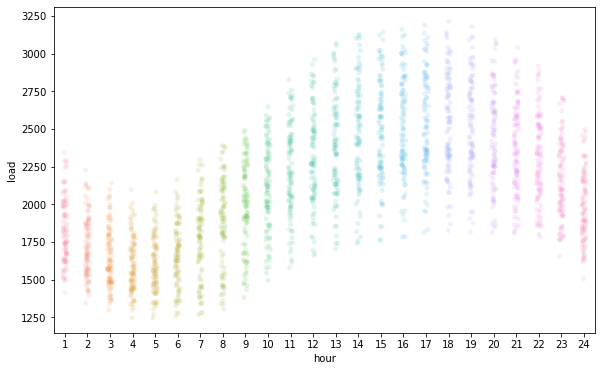

In [5]:
data = long_data.loc[(long_data['DT'].dt.year == 2017) & (long_data['Season'] == 'Summer')]

height = 6
fig = plt.figure(figsize=(phi * height,height))
sns.stripplot(data = data, x='hour', y='load',alpha=0.15)

- Turn values into categorical

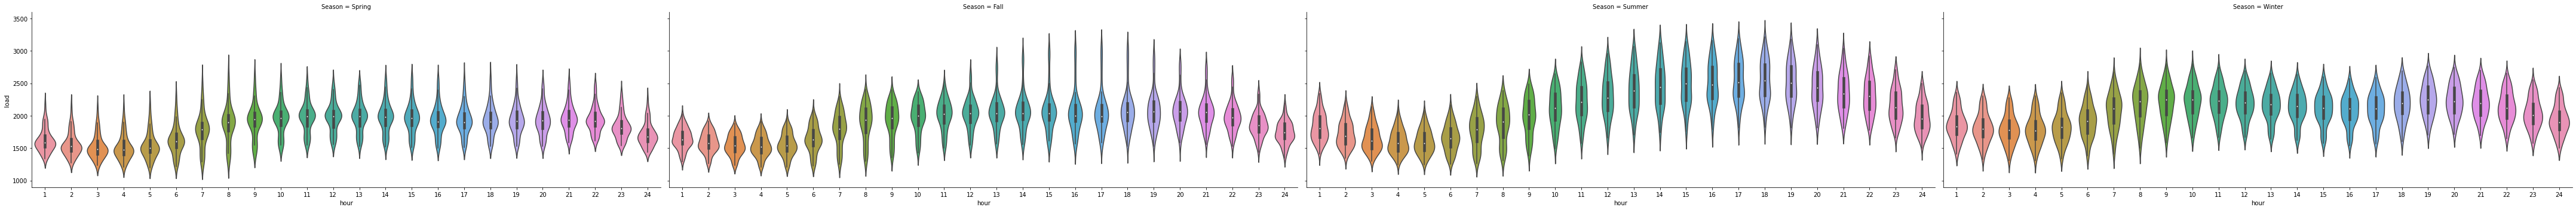

In [6]:
data = long_data.loc[(long_data['DT'].dt.year == 2017)]

sns.catplot(data = data, x='hour', y='load',alpha=0.15, col='Season', kind='violin', aspect=3, col_order=['Spring','Fall','Summer','Winter'])

**2017 Sesonal trend**

We can see that in 2017 Spring and Fall have quite consistent points, they are clustered close to each other. On the other hand Summer and Winter data is quite scattered. 

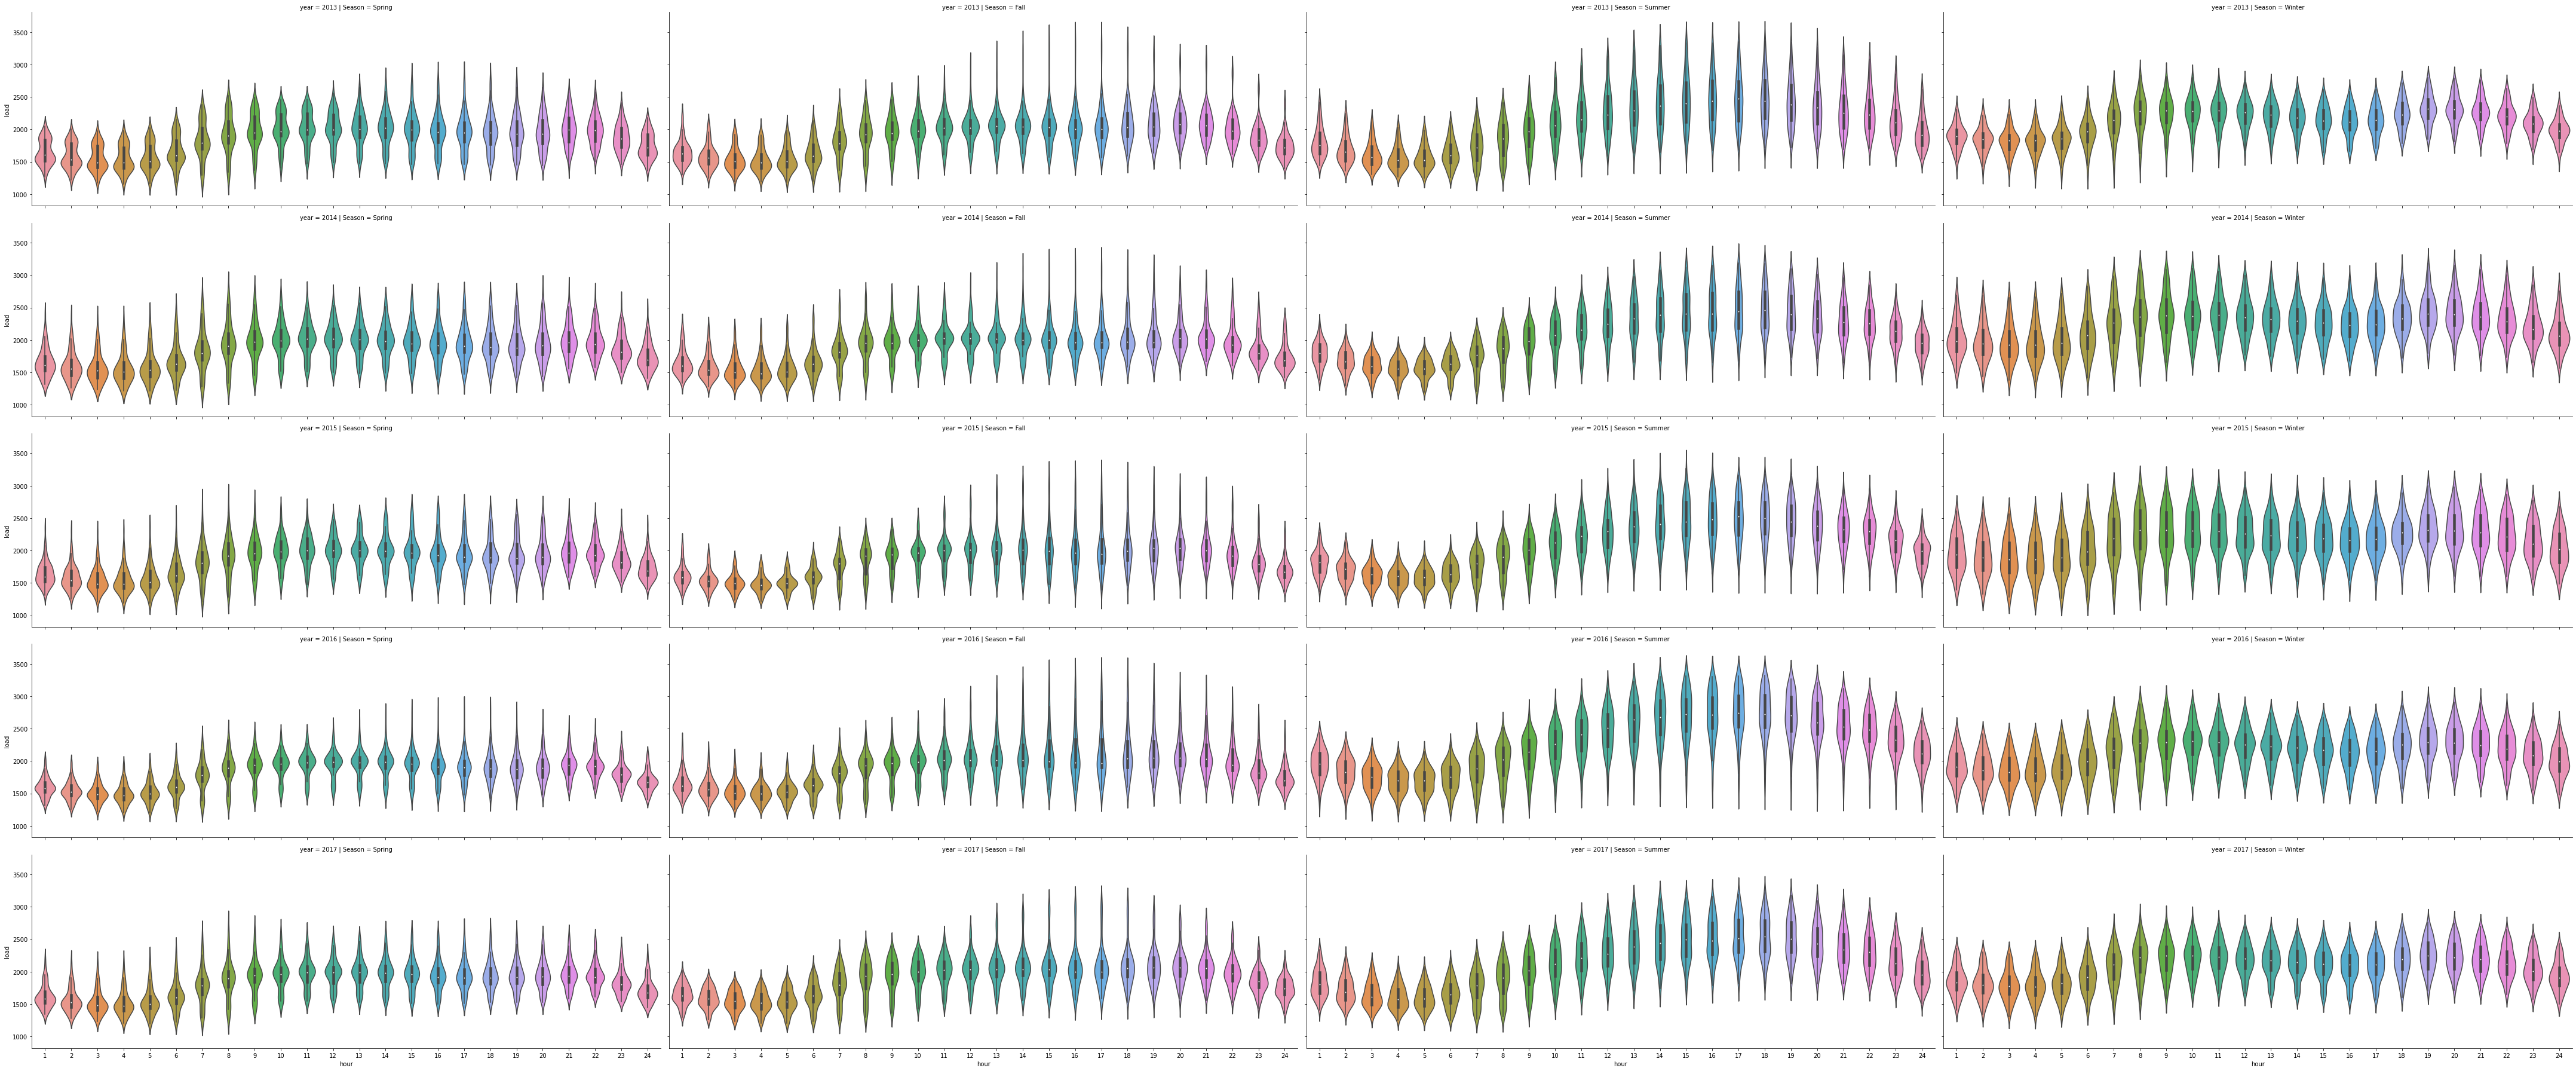

In [7]:
data = long_data.copy(deep=True)

data['year'] = data['DT'].dt.year

sns.catplot(data = data, x='hour', y='load',alpha=0.15, col='Season', row='year', kind='violin', aspect=3, col_order=['Spring','Fall','Summer','Winter'])

We can see that for all the years the hourly load in spring and fall is quite consistent over all the days while just like 2017, the hourly load in summer and winter is quite spread out.

In [8]:
long_data['Season'] = long_data['Season'].astype('category')

Reading the weather data from `DPLWeather` sheet

In [9]:
weather_data = pd.read_excel('HandBookData.xlsx', sheet_name='DPLWeather', engine='openpyxl')

weather_data.sample(5)

,dt,MaxTemp,AvgTemp,LowTemp,MaxDewPoint,AvgDepPoint,LowDewPoint,MaxRelHumidity,AvgRelHumidity,LowHumidity,...,AvgPressure,LowPressure,MaxVisibility,AvgVisibility,LowVisibility,MaxWindSpeed,AvgWindSpeed,MaxGust,Precipitation,EventCategory
326,2013-11-23,35,28,20,27,20,9,92,71,50,...,30.43,30.37,10,9,2,28,12,37,T,16.0
55,2013-02-25,43,33,22,26,23,19,88,69,49,...,30.13,29.96,10,9,6,17,8,21,0,99.0
671,2014-11-03,66,51,36,27,23,20,56,38,19,...,30.26,30.17,10,10,10,23,14,29,0,99.0
1076,2015-12-13,62,59,55,58,55,51,100,86,72,...,29.97,29.74,10,10,5,18,11,23,0,99.0
379,2014-01-15,31,24,17,19,16,13,84,71,58,...,30.04,29.92,10,8,2,30,12,35,T,16.0


Joining `DLLoad` and `DPLWeather` ddata to capture complete information

In [10]:
complete_data = long_data.set_index('DT').join(weather_data.set_index('dt'))

complete_data.reset_index(inplace=True)
complete_data.sample(5)

,index,Season,Month,DOW,hour,load,MaxTemp,AvgTemp,LowTemp,MaxDewPoint,...,AvgPressure,LowPressure,MaxVisibility,AvgVisibility,LowVisibility,MaxWindSpeed,AvgWindSpeed,MaxGust,Precipitation,EventCategory
19271,2015-03-14,Spring,3,Saturday,24,1575.0,60,48,36,51,...,29.99,29.95,10,7,3,20,10,24,0.44,11.0
18240,2015-01-31,Winter,1,Saturday,1,2110.0,37,27,17,30,...,30.34,30.21,10,9,4,17,10,20,0.04,13.0
598,2013-01-25,Winter,1,Friday,23,2217.0,24,21,17,19,...,30.17,30.03,10,6,0,17,10,21,0.3,8.0
26450,2016-01-08,Winter,1,Friday,3,1792.0,49,41,33,49,...,29.92,29.83,10,4,0,18,9,24,0.3,11.0
10370,2014-03-09,Spring,3,Sunday,3,NaN,45,36,27,30,...,30.18,29.99,10,6,1,16,9,21,T,99.0


Filling the `NaN` values of `load` using forward fill technique as the `NaN` values are few and spreadd out across the data, so using the previous timestamp load data isn't going to affect data accuracy

In [11]:
complete_data['load'] = complete_data['load'].fillna(method='ffill')

Plotting the `MaxTemp`, `MinTemp` and `AvgTemp`

<AxesSubplot:xlabel='index', ylabel='MaxTemp'>

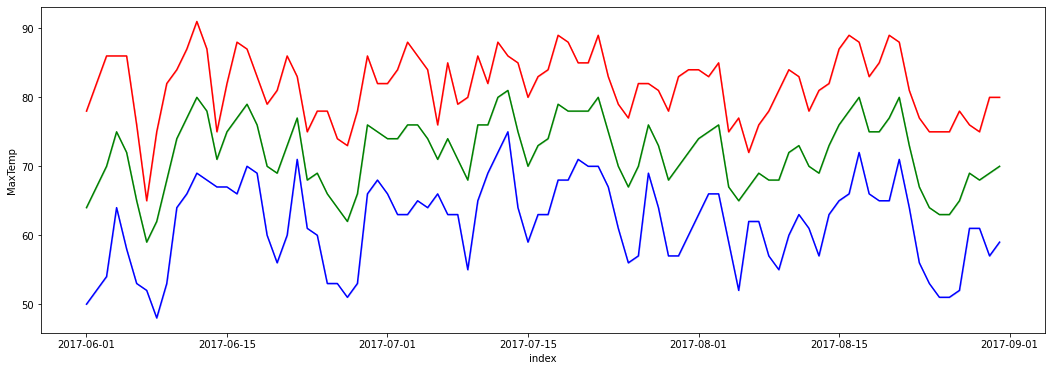

In [12]:
data = complete_data.loc[(complete_data['index'].dt.year == 2017) & (complete_data['Season'] == 'Summer')]
fig = plt.figure(figsize=(6*3, 6))
sns.lineplot(data=data, x='index', y='MaxTemp', color='r')
sns.lineplot(data=data, x='index', y='LowTemp', color='b')
sns.lineplot(data=data, x='index', y='AvgTemp', color='g')
# sns.relplot(data=data, x='index', y='MaxTemp','LowTemp', kind='line', aspect=3)

In [13]:
data = complete_data.copy(deep=True)
data['MaxGustNew'] = data['MaxGust'].replace('-', '0', regex=False)

# data.loc[data['MaxGustNew'].notna()]
complete_data['MaxGust'] = data['MaxGustNew']
complete_data['MaxGust'] = complete_data['MaxGust'].astype(np.float64)

In [14]:
complete_data['EventCategory'] = complete_data['EventCategory'].fillna('99')
complete_data['EventCategory'] = complete_data['EventCategory'].astype('category')
complete_data['DOW'] = complete_data['DOW'].astype('category')
complete_data['Month'] = complete_data['Month'].astype('category')
complete_data['hour'] = complete_data['hour'].astype('category')

In [15]:
complete_data['Precipitation'] = complete_data['Precipitation'].replace('T', '99', regex=False)
complete_data['Precipitation'] = complete_data['Precipitation'].astype(np.float64)

In [16]:
complete_data['Weekend'] = np.where((complete_data['DOW'] == 'Saturday') | (complete_data['DOW'] == 'Sunday'), 1, 0)

complete_data.sample(5)

,index,Season,Month,DOW,hour,load,MaxTemp,AvgTemp,LowTemp,MaxDewPoint,...,LowPressure,MaxVisibility,AvgVisibility,LowVisibility,MaxWindSpeed,AvgWindSpeed,MaxGust,Precipitation,EventCategory,Weekend
41440,2017-09-23,Fall,9,Saturday,17,2758.0,90,77,63,67,...,30.06,10,9,5,10,4,14.0,0.00,99.0,1
16447,2014-11-17,Fall,11,Monday,8,2275.0,33,24,14,32,...,29.77,10,4,0,29,15,34.0,0.26,8.0,0
201,2013-01-09,Winter,1,Wednesday,10,2222.0,46,39,31,38,...,30.20,10,9,7,20,11,24.0,0.06,11.0,0
25613,2015-12-04,Winter,12,Friday,6,2045.0,34,29,23,30,...,30.47,7,3,0,10,5,13.0,0.00,1.0,0
42150,2017-10-23,Fall,10,Monday,7,1799.0,66,57,48,62,...,29.62,10,9,2,25,13,30.0,0.44,99,0


Dropping NaN values as a final check

In [18]:
complete_data = complete_data.dropna()

In [19]:
# Let's just take a minimalistic number of fields for a simple model

data = complete_data[['Month','DOW','hour','load','AvgTemp', 'Weekend']]
data.dtypes

Month      category
DOW        category
hour       category
load        float64
AvgTemp       int64
Weekend       int64
dtype: object

<AxesSubplot:xlabel='AvgTemp', ylabel='load'>

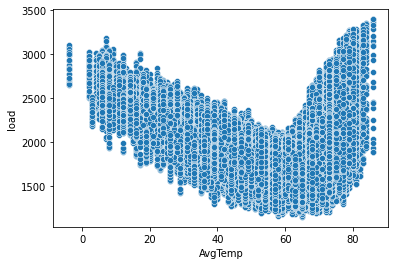

In [20]:
sns.scatterplot(data = data, x='AvgTemp',y='load')

<AxesSubplot:xlabel='AvgTemp', ylabel='load'>

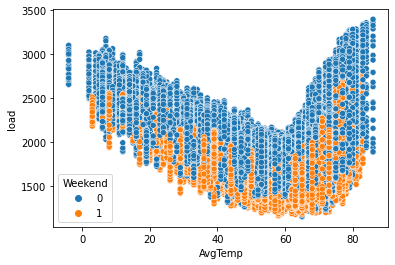

In [21]:
t_data = data.loc[data['hour'] == 1]
sns.scatterplot(data=data, x='AvgTemp', y='load', hue='Weekend')

In [22]:
# Let's make 24 data arrays to create 24 equations (one for each hour)
datas = []
for i in range(1,25):
    datas.append(data.loc[data['hour'] == i])
    
datas[0].head()
                          

,Month,DOW,hour,load,AvgTemp,Weekend
0,1,Tuesday,1,1723.0,26,0
24,1,Wednesday,1,1874.0,16,0
48,1,Thursday,1,2141.0,20,0
72,1,Friday,1,1989.0,24,0
96,1,Saturday,1,1961.0,28,1


In [23]:
# Let's add polynomial values for avgTemp
for d in datas:
    d.loc[:,'AvgTemp2'] = d.loc[:,'AvgTemp'].apply(lambda x: x**2)
    d.loc[:,'AvgTemp3'] = d.loc[:,'AvgTemp'].apply(lambda x: x**3)
    d.loc[:,'AvgTemp_weekend'] = d.loc[:,('AvgTemp', 'Weekend')].apply(lambda x: x['AvgTemp'] * x['Weekend'], axis=1)
    d.loc[:,'AvgTemp2_weekend'] = d.loc[:,('AvgTemp2', 'Weekend')].apply(lambda x: x['AvgTemp2'] * x['Weekend'], axis=1)
    d.loc[:,'AvgTemp3_weekend'] = d.loc[:,('AvgTemp3', 'Weekend')].apply(lambda x: x['AvgTemp3'] * x['Weekend'], axis=1)
datas[0].head()

/tmp/ipykernel_4816/720961836.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d.loc[:,'AvgTemp2'] = d.loc[:,'AvgTemp'].apply(lambda x: x**2)
/tmp/ipykernel_4816/720961836.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d.loc[:,'AvgTemp3'] = d.loc[:,'AvgTemp'].apply(lambda x: x**3)
/tmp/ipykernel_4816/720961836.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

,Month,DOW,hour,load,AvgTemp,Weekend,AvgTemp2,AvgTemp3,AvgTemp_weekend,AvgTemp2_weekend,AvgTemp3_weekend
0,1,Tuesday,1,1723.0,26,0,676,17576,0,0,0
24,1,Wednesday,1,1874.0,16,0,256,4096,0,0,0
48,1,Thursday,1,2141.0,20,0,400,8000,0,0,0
72,1,Friday,1,1989.0,24,0,576,13824,0,0,0
96,1,Saturday,1,1961.0,28,1,784,21952,28,784,21952


In [24]:
datas[0].head()

,Month,DOW,hour,load,AvgTemp,Weekend,AvgTemp2,AvgTemp3,AvgTemp_weekend,AvgTemp2_weekend,AvgTemp3_weekend
0,1,Tuesday,1,1723.0,26,0,676,17576,0,0,0
24,1,Wednesday,1,1874.0,16,0,256,4096,0,0,0
48,1,Thursday,1,2141.0,20,0,400,8000,0,0,0
72,1,Friday,1,1989.0,24,0,576,13824,0,0,0
96,1,Saturday,1,1961.0,28,1,784,21952,28,784,21952


In [25]:
nn_datas = []

for d in datas:
    nn_datas.append(d[['Month','DOW','hour','load','AvgTemp','Weekend']])
    
nn_datas[0]

,Month,DOW,hour,load,AvgTemp,Weekend
0,1,Tuesday,1,1723.0,26,0
24,1,Wednesday,1,1874.0,16,0
48,1,Thursday,1,2141.0,20,0
72,1,Friday,1,1989.0,24,0
96,1,Saturday,1,1961.0,28,1
...,...,...,...,...,...,...
43704,12,Wednesday,1,2185.0,6,0
43728,12,Thursday,1,2273.0,9,0
43752,12,Friday,1,2114.0,16,0
43776,12,Saturday,1,2047.0,8,1


In [26]:
final_nn_datas = []
for d in nn_datas:
    ohe_values = pd.get_dummies(d[['Month','DOW']])
    t_d = d.drop(['Month','DOW','hour'], axis=1)
    final_nn_datas.append(pd.concat((t_d, ohe_values), axis=1))
    
final_nn_datas[0]

,load,AvgTemp,Weekend,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,...,Month_10,Month_11,Month_12,DOW_Friday,DOW_Monday,DOW_Saturday,DOW_Sunday,DOW_Thursday,DOW_Tuesday,DOW_Wednesday
0,1723.0,26,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
24,1874.0,16,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
48,2141.0,20,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
72,1989.0,24,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
96,1961.0,28,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43704,2185.0,6,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
43728,2273.0,9,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
43752,2114.0,16,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
43776,2047.0,8,1,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


In [27]:
from sklearn.preprocessing import StandardScaler

final_norm_datas = []
norms = {
    'load': [],
    'temp': []
}


for i, d in enumerate(final_nn_datas):
    load_norm = StandardScaler()
    load_d = load_norm.fit_transform(d['load'].values.reshape(-1,1))
    load_d = pd.DataFrame(load_d, columns=['load_norm'], index = range(i,43801+i, 24))
    
    temp_norm = StandardScaler()
    temp_d = temp_norm.fit_transform(d['AvgTemp'].values.reshape(-1,1))
    temp_d = pd.DataFrame(temp_d, columns=['temp_norm'], index = range(i,43801+i, 24))
    
    t_d = d.drop(['load','AvgTemp'], axis=1)
    
    final_norm_datas.append(pd.concat((load_d, temp_d, t_d), axis=1))

final_norm_datas[1]
    

    

,load_norm,temp_norm,Weekend,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,...,Month_10,Month_11,Month_12,DOW_Friday,DOW_Monday,DOW_Saturday,DOW_Sunday,DOW_Thursday,DOW_Tuesday,DOW_Wednesday
1,-0.066995,-1.430696,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
25,0.637859,-1.953698,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
49,1.699237,-1.744497,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
73,1.031265,-1.535296,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
97,0.916522,-1.326095,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43705,1.949214,-2.476701,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
43729,2.264759,-2.319800,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
43753,1.600886,-1.953698,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
43777,1.207479,-2.372100,1,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


In [43]:
from sklearn.svm import SVR

model = SVR(kernel='poly', degree=3)

# Let's just do it for final_datas[0]

x_data = final_norm_datas[0].values[:,1:]
y_data = final_norm_datas[0].values[:,0]

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, random_state=1)

model.fit(x_train, y_train)

model.score(x_test, y_test)

0.7384308053569411

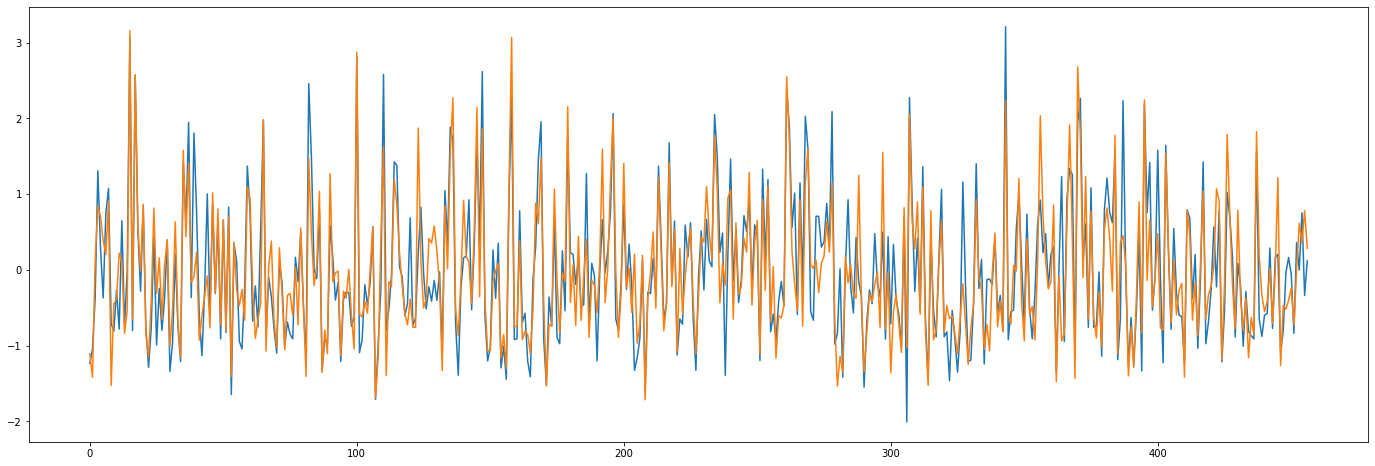

In [44]:
fig = plt.figure(figsize=(24,8))
plt.plot(y_test)
plt.plot(model.predict(x_test))

In [30]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept = False)

# Let's just do it for final_datas[0]

x_data = final_norm_datas[0].values[:,1:]
y_data = final_norm_datas[0].values[:,0]

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, random_state=1)

model.fit(x_train, y_train)

model.score(x_test, y_test)

0.4816473627224348

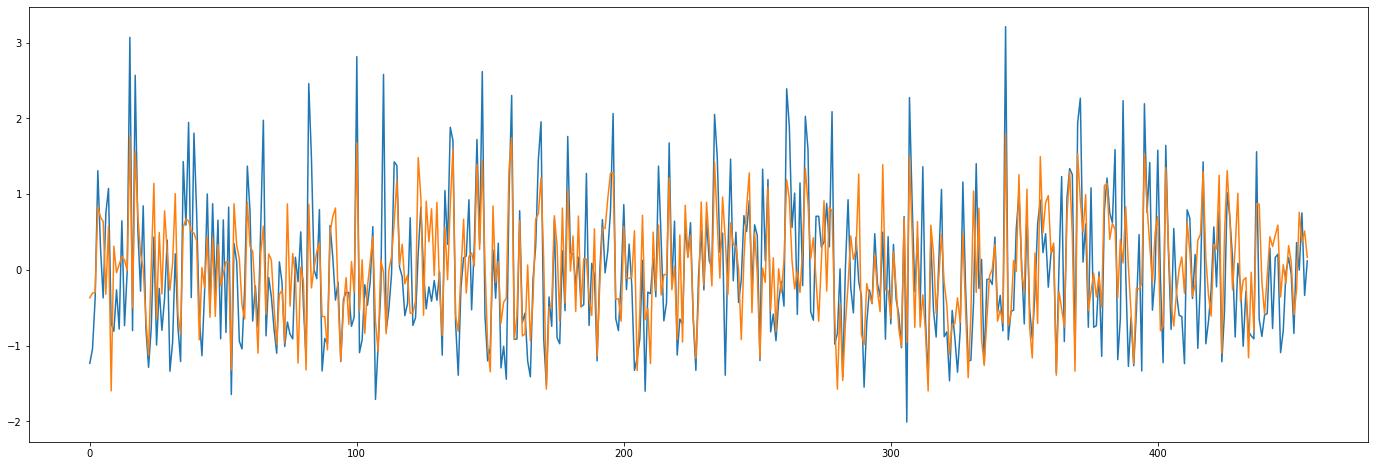

In [31]:
fig = plt.figure(figsize=(24,8))
plt.plot(y_test)
plt.plot(model.predict(x_test))